In [1]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

In [35]:
df = pd.read_csv('climate_tweets.csv')

In [36]:
df.shape

(6090, 1)

In [37]:
df.head(10)

,tweet
0,Global warming report urges governments to act...
1,Fighting poverty and global warming in Africa ...
2,Carbon offsets: How a Vatican forest failed to...
3,Carbon offsets: How a Vatican forest failed to...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...
6,Global warming evidence all around us|A messag...
7,Migratory Birds' New Climate Change Strategy: ...
8,Southern Africa: Competing for Limpopo Water: ...
9,"Global warming to impact wheat, rice productio..."


In [39]:
df.tweet.unique().shape

(5541,)

In [40]:
# make a new column to highlight retweets
df['is_retweet'] = df['tweet'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()

773

In [41]:
df.loc[df['is_retweet']].tweet.unique().size

677

In [42]:
# 10 most repeated tweets
df.groupby(['tweet']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,tweet,counts
3131,No matter if you believe in global warming or ...,20
4555,Take Action @change: Help Protect Wildlife Hab...,14
4027,RT @newtgingrich: Historic snow storm in washi...,9
1765,Fight Climate Change From All Fronts: [link],8
1626,Earth's polar ice sheets vulnerable to even mo...,7
1941,Global Warming Dent's El Ni'o's Protective Shi...,7
1799,Foes of California's global warming law pour m...,6
1351,Coalition of the Tired of Waiting: Fighting Cl...,6
4271,SCIENCE: Scientists explore the evolution of c...,6
1040,Carbon offsets: How a Vatican forest failed to...,6


<ipython-input-43-5254c02bbfae>:15: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


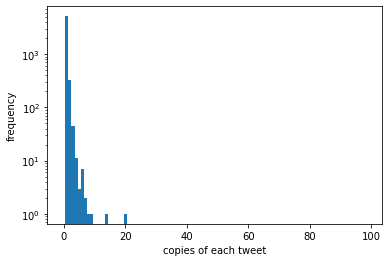

In [43]:
# number of times each tweet appears
counts = df.groupby(['tweet']).size()\
           .reset_index(name='counts')\
           .counts

# define bins for histogram
my_bins = np.arange(0,100, 1)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,100, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [16]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [17]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [18]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [44]:
df['clean_tweet'] = df.tweet.apply(clean_tweet)

In [45]:
df.head(10)

,tweet,is_retweet,clean_tweet
0,Global warming report urges governments to act...,False,global warm report urg govern act brussel belg...
1,Fighting poverty and global warming in Africa ...,False,fight poverti global warm africa
2,Carbon offsets: How a Vatican forest failed to...,False,carbon offset vatican forest fail reduc global...
3,Carbon offsets: How a Vatican forest failed to...,False,carbon offset vatican forest fail reduc global...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,False,uruguay tool need vulner climat chang
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,True,ocean salti show global warm intensifi water ...
6,Global warming evidence all around us|A messag...,False,global warm evid around us messag global warm ...
7,Migratory Birds' New Climate Change Strategy: ...,False,migratori bird new climat chang strategi stay ...
8,Southern Africa: Competing for Limpopo Water: ...,False,southern africa compet limpopo water climat ch...
9,"Global warming to impact wheat, rice productio...",False,global warm impact wheat rice product india lu...


In [46]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [47]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

LDAmodel = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [48]:
LDAmodel.fit(tf)

LatentDirichletAllocation(random_state=0)

In [24]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [49]:
no_top_words = 10
display_topics(LDAmodel, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,1220.2,global,666.5,global,1147.2,global,473.1,climat,422.0,global,783.0,chang,666.1,warm,167.9,climat,568.3,climat,529.9
1,chang,1184.5,warm,658.1,warm,1102.1,warm,450.7,chang,401.8,warm,764.7,climat,661.6,#climate,139.2,chang,550.5,chang,520.6
2,via,257.9,snow,160.5,scientist,150.2,believ,101.3,legisl,123.2,gore,137.1,energi,178.8,volcano,128.9,new,321.1,peopl,153.4
3,scienc,112.9,#tcot,121.6,say,87.1,california,87.1,us,105.1,snow,123.7,u,109.8,global,128.6,bill,116.9,world,151.3
4,news,79.5,like,99.0,scienc,71.7,blame,82.1,via,60.5,al,122.1,via,96.5,chang,122.0,senat,106.1,confer,110.1
5,day,77.8,blizzard,90.9,debat,66.6,law,78.6,say,55.9,great,94.1,nation,89.0,help,114.1,agenc,95.1,bill,106.4
6,earth,68.2,dc,86.5,man,61.1,report,77.8,video,55.9,cold,77.1,make,74.5,take,96.8,immigr,77.7,talk,94.8
7,trial,68.1,think,83.3,made,54.0,save,61.8,place,54.1,call,76.5,impact,67.5,climat,76.7,obama,75.6,graham,92.1
8,clinic,68.1,due,80.1,show,51.9,money,56.1,good,52.6,#tcot,75.3,report,63.4,iceland,67.1,feder,67.1,un,77.6
9,carbon,64.5,make,70.4,water,50.6,live,49.3,human,48.2,one,72.1,issu,58.8,could,64.5,via,58.6,put,68.8


In [65]:
 perpl = LDAmodel.perplexity(tf)

In [66]:
perpl

138.33584337450603

In [67]:
score = LDAmodel.score(tf)
score

-188072.3886392263

In [29]:
from sklearn.decomposition import NMF
NMFmodel = NMF(n_components=number_of_topics, random_state=0, alpha=.1, l1_ratio=.5)

In [50]:
NMFmodel.fit(tf)

/Users/vinu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/vinu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(alpha=0.1, l1_ratio=0.5, n_components=10, random_state=0)

In [51]:
no_top_words = 10
display_topics(NMFmodel, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,10.8,global,9.3,via,7.7,snow,5.4,bill,5.2,new,6.0,#climate,4.9,peopl,3.8,say,4.4,#tcot,5.6
1,chang,9.8,warm,9.1,news,1.5,dc,1.9,senat,2.5,agenc,1.9,chang,4.6,world,3.4,report,3.3,#p,1.7
2,energi,0.3,make,0.3,humanitarian,0.6,gore,1.4,graham,1.6,obama,1.2,#global,1.0,earth,2.3,caus,2.4,#teaparty,1.0
3,scienc,0.3,could,0.2,chang,0.4,al,1.3,put,1.1,feder,1.2,#eco,0.8,confer,2.2,scientist,1.8,#gop,0.6
4,fight,0.3,scienc,0.2,india,0.3,mean,1.2,limbo,0.8,form,1.0,warm,0.7,right,1.3,us,1.0,scam,0.6
5,legisl,0.3,think,0.2,com,0.2,jr,1.0,exit,0.8,studi,0.7,us,0.4,bolivia,1.0,govern,0.8,dc,0.6
6,u,0.3,stop,0.2,un,0.1,storm,1.0,climat,0.7,administr,0.7,fact,0.3,day,1.0,may,0.8,gore,0.5
7,un,0.3,effect,0.2,environ,0.1,cold,0.9,compromis,0.7,propos,0.6,nasa,0.3,mother,1.0,u,0.4,#ocra,0.5
8,get,0.2,volcano,0.2,mean,0.1,washington,0.9,prepar,0.7,york,0.6,#p,0.3,indigen,0.4,carbon,0.3,al,0.5
9,action,0.2,believ,0.2,impact,0.1,ago,0.9,immigr,0.6,report,0.5,thought,0.3,cochabamba,0.3,china,0.3,#tlot,0.5


In [32]:
from sklearn.decomposition import TruncatedSVD
LSAmodel = TruncatedSVD(n_components=number_of_topics, algorithm='randomized', n_iter=10, random_state=42)

In [52]:
LSAmodel.fit(tf)

TruncatedSVD(n_components=10, n_iter=10, random_state=42)

In [64]:
from sklearn.decomposition import PCA
PPCA = PCA(n_components=number_of_topics, svd_solver='randomized') 

ImportError: cannot import name 'ProbabilisticPCA' from 'sklearn.decomposition' (/Users/vinu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/__init__.py)

In [53]:
no_top_words = 10
display_topics(LSAmodel, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,0.6,global,0.6,via,0.9,snow,0.7,bill,0.5,new,0.7,#climate,0.5,peopl,0.5,say,0.5,#tcot,0.6
1,chang,0.5,warm,0.6,news,0.2,dc,0.3,senat,0.3,agenc,0.2,bill,0.4,world,0.5,#tcot,0.3,news,0.4
2,global,0.4,snow,0.0,humanitarian,0.1,bill,0.2,climat,0.2,obama,0.2,chang,0.4,earth,0.3,report,0.3,gore,0.2
3,warm,0.4,#tcot,0.0,snow,0.0,gore,0.2,via,0.2,feder,0.1,senat,0.2,confer,0.3,caus,0.3,al,0.2
4,via,0.1,dc,0.0,mean,0.0,al,0.2,graham,0.2,report,0.1,via,0.2,bill,0.2,scientist,0.2,#p,0.2
5,new,0.0,gore,0.0,india,0.0,#tcot,0.2,put,0.1,climat,0.1,new,0.2,new,0.2,us,0.1,make,0.2
6,bill,0.0,caus,0.0,com,0.0,mean,0.2,limbo,0.1,form,0.1,graham,0.1,right,0.2,world,0.1,blizzard,0.1
7,snow,0.0,al,0.0,un,0.0,washington,0.1,exit,0.1,bill,0.1,#global,0.1,bolivia,0.1,#p,0.1,#teaparty,0.1
8,news,0.0,believ,0.0,cold,0.0,jr,0.1,talk,0.1,studi,0.1,warm,0.1,mother,0.1,believ,0.1,wors,0.1
9,report,0.0,stop,0.0,jr,0.0,senat,0.1,immigr,0.1,administr,0.1,put,0.1,day,0.1,make,0.1,time,0.1


In [60]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp = NMFmodel.components_[index]
  vocab_comp = zip(tf_feature_names, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

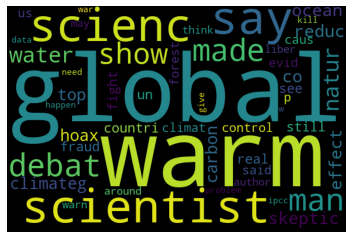

In [59]:
draw_word_cloud(2)

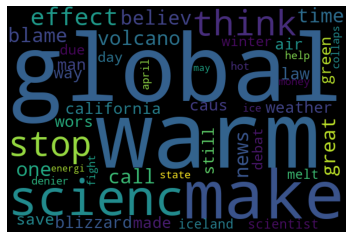

In [63]:
draw_word_cloud(1)